# Code

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In this section I will be importing and cleaning up the data in order to create my model

In [18]:
#importing data
df = pd.read_csv('allegations_202007271729.csv')
df

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33353,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Discourtesy,Word,66.0,Moving violation,Moving violation summons issued,Unsubstantiated
33354,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Abuse of Authority,Interference with recording,66.0,Moving violation,Moving violation summons issued,Unsubstantiated
33355,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Abuse of Authority,Search (of person),66.0,Moving violation,Moving violation summons issued,Substantiated (Formalized Training)
33356,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Abuse of Authority,Vehicle search,66.0,Moving violation,Moving violation summons issued,Substantiated (Formalized Training)


In [477]:
# replacing Unknowns with NaN
police_data['complainant_ethnicity']= (police_data['complainant_ethnicity']
                                       .apply(lambda x: np.NaN if x =='Unknown'else x))

In [478]:
#replacing 'missing' values with NaN
police_data['complainant_age_incident'] = (police_data['complainant_age_incident']
                                           .apply(lambda x: np.NaN if x==0.0 or x==-4301.0 or x== -1.0 else x))

### Baseline Model

In [479]:
# importing sklearn functions
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

The purpose of my linear regression model will be to predict the amount of time a complaint remains open from the month the report was received to the month the investigation was closed. I will be using the following features to create my linear regression model: age of complainant, gender of complainant, ethnicity of the complainant and reported officer, the year the report was received and the type of infraction that was reported. I will be using R^2 to determine whether or not the model is good.

In [480]:
# calculating number of months taken to resolve complaint
months_apart = (
    ((police_data['year_closed'] - police_data['year_received'])*12 - 
                police_data['month_received']) + police_data['month_closed']
)
police_data = police_data.assign(months_apart = months_apart)

In [481]:
# Numerical Variables
numcols = ['complainant_age_incident','year_received']
# Categorical Variables
catcols = ['complainant_ethnicity', 'complainant_gender', 'mos_ethnicity','fado_type']

In [482]:
# One hot encoding categorical variables and leaving numerical varabiles as is
ct = ColumnTransformer(transformers = [('ohe', OneHotEncoder(), catcols), ('num', FunctionTransformer(lambda x:x), numcols)])
pl = Pipeline(steps = [('preproc',ct),('lr',LinearRegression())])

In [483]:
# selecting necessary columns from dataframe
train_df = (police_data[['complainant_ethnicity', 'complainant_gender', 'mos_ethnicity','complainant_age_incident',
                         'fado_type','year_received','months_apart']].dropna())
#Splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('months_apart',axis=1),train_df.months_apart)

In [484]:
# Fitting model with training data
pl.fit(X_train,y_train)
# Obtaining R^2 of test set
pl.score(X_test,y_test)

0.0665559399187462

As we can see above, the R^2 of my model is about 0.067, which means that only about 6.7% of the variance in the amount of months a case is resolved is dependent on the features I selected. This most likely means that the features I selected do not  have a large impact on the amount of time nedeed to resolve a case. In the following section I will try to improve my baseline model in order to make more accurate predictions and achieve a higher R^2 by creating new features.

### Final Model

In [485]:
# Importing sklearn function for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In this section I will try to improve upon my baseline model by creating new features such as whether or not the complainant and officer were the same ethnicity, whether or not the complainant was a male and standardizing the year and age columns. Additionally, I will also account for multicollinearity by using principal component analysis to get rid of unneeded features.

In [486]:
# Creating new variables
train_df = train_df.assign(same_ethnicity = (train_df['mos_ethnicity'] == train_df['complainant_ethnicity']).astype(int),
                          is_male = (train_df['complainant_gender'] == 'Male').astype(int))

In [487]:
# Creating new dataframe, dropping columns used to create new features in previous step in order to prevent multicollinearity
final_df = train_df.drop(['mos_ethnicity', 'complainant_ethnicity', 'complainant_gender'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('months_apart',axis=1), final_df.months_apart)

In [488]:
# Numerical variables
numcols = ['year_received', 'complainant_age_incident']
# Categorical Variables
catcols = ['fado_type']

In [489]:
# PCA to get take care of Multicollinearity, n_components obtained from steps below
cats = Pipeline([
    ('ohe', OneHotEncoder(sparse=False)),
    ('pca', PCA(svd_solver='full',n_components=3))
])

In [490]:
# Transforming columns
ct = ColumnTransformer(transformers = [('cat', cats, catcols),
                                       ('std',StandardScaler(),numcols),
                                       ('binary',FunctionTransformer(lambda x:x),['same_ethnicity','is_male'])
                                      ])
# Final Model Pipeline
pp = Pipeline(steps = [('preproc',ct), 
                       ('lr',LinearRegression()) 
                      ])

In [491]:
# Searching for necessary components to keep in pca, using 1-4 since fado_type only has 4 unique values
params = {'preproc__cat__pca__n_components':[1,2,3,4]}
# Performing GridSearchCV on pipeline to find necessary components of one hot encoded columns to keep
grids = GridSearchCV(pp,param_grid=params,cv=5)

In [492]:
grids.fit(X_train,y_train)
grids.best_params_

{'preproc__cat__pca__n_components': 3}

In [493]:
# Fitting training data
pp.fit(X_train,y_train)
# Obtaining R^2
pp.score(X_test,y_test)

0.07142600219987949

As we can see above our R^2 is about .071, which means that only about 7.1% of the variance in months_apart is explained by the parameters I chose. This means that the new features I created did not have a large effect on the R^2. Although I obtained a higher R^2, the difference is very minimal and most likely due to sampling variability in the training and testing sets. All in all, my final model did not really improve upon the baseline model, which most likely means that in order to obtain a higher R^2 I will need to use other completely unique features. 

### Fairness Evaluation

For my fairness evaluation I will be testing whether my final model is fairer for younger or older people. First I will assign everyone a binary variable representing whether or not they are older than 40. Then, I will obtain the difference between the  R^2's of the young and old subset using my final model. After obtaining the observed difference, I will perform a permutation test in which I shuffle the new binary variable and calculate the differences in R^2 between the new "old" and "young" groups. I will test the following hypotheses:

H_0: The model is fair,  the R^2 for the two subsets are roughly the same

H_1: The model is not fair, the R^2 for the two subsets are not the same

I will use a 1% significance level.

In [494]:
# Assigning everyone a label of wheter or not they are older than 40
perm = final_df.assign(is_old = (train_df1['complainant_age_incident'] > 40).astype(int))
perm.head()

,complainant_age_incident,fado_type,year_received,months_apart,same_ethnicity,is_male,is_old
0,38.0,Abuse of Authority,2019,10,0,0,0.0
1,26.0,Discourtesy,2011,9,0,1,0.0
2,26.0,Offensive Language,2011,9,0,1,0.0
3,45.0,Abuse of Authority,2012,14,0,1,1.0
5,31.0,Abuse of Authority,2017,5,0,1,0.0


In [495]:
young = perm[perm['is_old'] == 0]
# Calculating R^2 of young subset
real_young = pp.score(young.drop(['is_old','months_apart'],axis=1),young.months_apart)
real_young

0.0690154092542502

In [496]:
old = perm[perm['is_old'] == 1]
# Calculating R^2 of old subset
real_old = pp.score(old.drop(['is_old','months_apart'],axis=1),old.months_apart)
real_old

0.05213419297341415

In [497]:
# Difference in R^2's
obs = real_young - real_old
obs

0.016881216280836053

<AxesSubplot:ylabel='Frequency'>

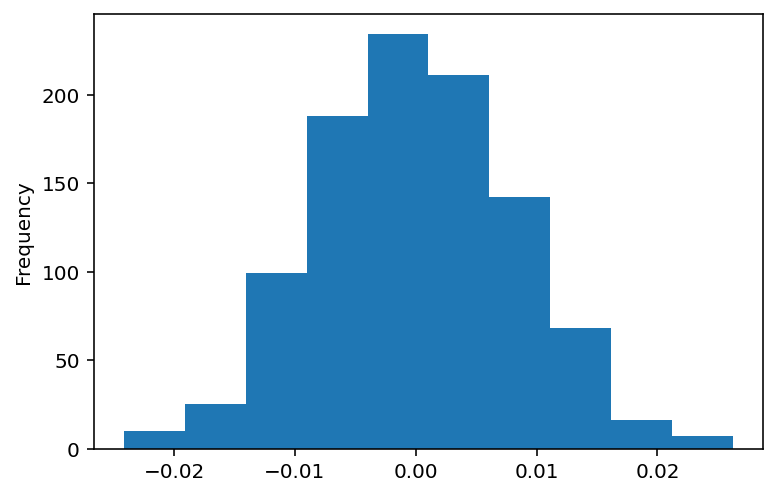

In [498]:
# List for keeping track of differences
diff = []
for _ in range(1000):
    # Shuffling labels
    shuffled_df = perm.assign(shuffled = perm['is_old'].sample(replace=True,frac=1).reset_index(drop=True))
    # Obtaining new dataframes of young and old people
    young_random = shuffled_df[shuffled_df['shuffled'] == 0]
    old_random = shuffled_df[shuffled_df['shuffled'] == 1]
    # Calculating R^2f for new subsets
    young_r  = pp.score(young_random.drop(['is_old','shuffled','months_apart'],axis=1) , young_random.months_apart)
    old_r  = pp.score(old_random.drop(['is_old','shuffled','months_apart'],axis=1) , old_random.months_apart)
    # Appending difference between R^2's
    diff.append(young_r - old_r)
pd.Series(diff).plot(kind='hist')

In [499]:
# P-Value
np.count_nonzero(diff >= obs) / 1000

0.019

As we can see above, the p-value I obtained is 0.019. If I compare that to the significance level I proposed in the beginning, we see that .019 > 0.01. Normally when the p-value is larger than the significance level, we state that we fail to reject the null hypothesis, however, since the difference is very small I cannot be 100% certain that this is the case. In order to be certain the model is fair I would need to collect more data and create more tests. All in all, it seems that the model is fair, but I cannot make a definitive conclusion with the given results.